<a href="https://colab.research.google.com/github/Esinam18/403-ASSIGNMENTS/blob/main/split_merge_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


We start by importing the necessary libraries for the split and merge segmentation

numpy is used for array manipulation and mathematical operations.

matplotlib.pyplot is used to visualize images and segmentation results.

cv2 (OpenCV) is used for image creation, shape drawing, and I/O operations.


In [2]:

def is_homogeneous(region, threshold=10):
    if region.size == 0:
        return True
    return np.std(region) < threshold


Determines whether a given region is uniform (homogeneous) based on the standard deviation of pixel values.

Smaller standard deviation → more uniform.

threshold controls sensitivity: lower threshold → stricter homogeneity.

In [3]:
def split_region(image, threshold=15):

    regions = []

    def recursive_split(x, y, w, h):
        region = image[y:y+h, x:x+w]
        if is_homogeneous(region, threshold):
            regions.append([x, y, w, h])
        else:
            hw, hh = w // 2, h // 2
            if hw > 0 and hh > 0:
                recursive_split(x, y, hw, hh)
                recursive_split(x + hw, y, w - hw, hh)
                recursive_split(x, y + hh, hw, h - hh)
                recursive_split(x + hw, y + hh, w - hw, h - hh)
            else:
                regions.append([x, y, w, h])  # stop splitting very small regions
    recursive_split(0, 0, image.shape[1], image.shape[0])
    return regions


Uses quadtree decomposition: recursively divides a region into 4 quadrants if it is not homogeneous.

Stops splitting when regions are homogeneous or too small.

Returns a list of rectangles representing homogeneous regions.

In [4]:
def merge_regions(regions, image, threshold=15):
    merged = regions.copy()
    changed = True

    while changed:
        changed = False
        new_merged = []
        skip_indices = set()
        for i, r1 in enumerate(merged):
            if i in skip_indices:
                continue
            x1, y1, w1, h1 = r1
            merged_flag = False
            for j, r2 in enumerate(merged):
                if j <= i or j in skip_indices:
                    continue
                x2, y2, w2, h2 = r2
                # Check adjacency
                if (x1 == x2 and w1 == w2 and (y1+h1==y2 or y2+h2==y1)) or \
                   (y1 == y2 and h1 == h2 and (x1+w1==x2 or x2+w2==x1)):
                    combined_region = image[min(y1, y2):max(y1+h1, y2+h2),
                                            min(x1, x2):max(x1+w1, x2+w2)]
                    if is_homogeneous(combined_region, threshold):
                        new_region = [min(x1, x2), min(y1, y2),
                                      max(x1+w1, x2+w2)-min(x1, x2),
                                      max(y1+h1, y2+h2)-min(y1, y2)]
                        new_merged.append(new_region)
                        skip_indices.add(j)
                        merged_flag = True
                        changed = True
                        break
            if not merged_flag:
                new_merged.append(r1)
        merged = new_merged
    return merged


Iteratively checks all adjacent regions to see if they can be merged without violating the homogeneity criterion.

Merges horizontally or vertically adjacent regions.

Ensures segmentation is not too fragmented, reducing the number of regions.

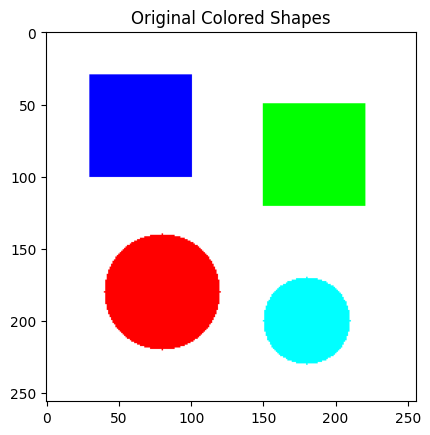

In [5]:
def generate_colored_shapes_image(width=256, height=256):

    img = np.ones((height, width, 3), dtype=np.uint8) * 255  # white background

    # Draw rectangles
    cv2.rectangle(img, (30, 30), (100, 100), (255, 0, 0), -1)  # red
    cv2.rectangle(img, (150, 50), (220, 120), (0, 255, 0), -1)  # green

    # Draw circles
    cv2.circle(img, (80, 180), 40, (0, 0, 255), -1)  # blue
    cv2.circle(img, (180, 200), 30, (255, 255, 0), -1)  # cyan

    return img

# Generate the image
color_image = generate_colored_shapes_image()
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)) # grayscale for segmentation
plt.title("Original Colored Shapes")
plt.show()




Creates a white canvas and draws colored rectangles and circles.

Converts the image to grayscale because Split and Merge works on intensity values.

In [6]:
# Split the image into homogeneous regions
regions = split_region(gray_image, threshold=15)
print(f"Number of regions after split: {len(regions)}")

# Merge adjacent homogeneous regions
merged_regions = merge_regions(regions, gray_image, threshold=15)
print(f"Number of regions after merge: {len(merged_regions)}")


Number of regions after split: 2260
Number of regions after merge: 410


First, recursively splits the grayscale image into homogeneous regions.

Then merges adjacent homogeneous regions to simplify the segmentation.

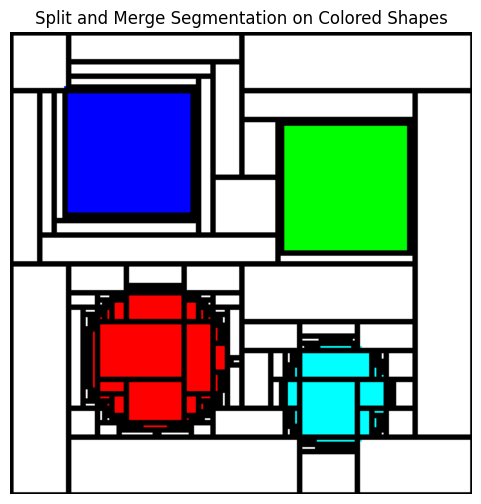

In [7]:
output_image = color_image.copy()
for (x, y, w, h) in merged_regions:
    cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 0, 0), 2)  # black rectangles

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Split and Merge Segmentation on Colored Shapes")
plt.axis('off')
plt.show()


In [8]:
cv2.imwrite("segmented_shapes.png", output_image)
print("Segmented image saved as 'segmented_shapes.png'")


Segmented image saved as 'segmented_shapes.png'
